In [77]:
import cftime
import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime as dt
import cartopy.crs as ccrs
import cartopy.util as cutil
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

from shapely import geometry
from cartopy.io.img_tiles import Stamen

%matplotlib widget
import os
import ee
import geemap
import requests
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp
from ipyleaflet import basemaps, basemap_to_tiles

#from oa import dataCollector

In [2]:
class dataCollector:
    def __init__(self, beam=None, oaurl=None, track=None, date=None, latlims=None, lonlims=None, verbose=False):
        if (beam is None) or ((oaurl is None) and (None in [track, date, latlims, lonlims])):
            raise Exception('''Please specify a beam and 
            - either: an OpenAltimetry API url, 
            - or: a track, date, latitude limits and longitude limits.''')
        else:
            if oaurl is not None:
                url = oaurl
                tofind = '&beamName='
                ids = url.find(tofind)
                while ids>-1:
                    url = url.replace(url[ids:ids+len(tofind)+4],'')
                    ids = url.find(tofind)
                iprod = url.find('/atl')
                url = url.replace(url[iprod:iprod+6],'/atlXX')
                url += tofind + beam + '&client=jupyter'

                idate = url.find('date=') + len('date=')
                date = url[idate:idate+10]
                itrack = url.find('trackId=') + len('trackId=')
                trackend = url[itrack:].find('&')
                track = int(url[itrack:itrack+trackend])
                bb = []
                for s in ['minx=', 'maxx=', 'miny=', 'maxy=']:
                    ids = url.find(s) + len(s)
                    ide = url[ids:].find('&')
                    bb.append(float(url[ids:ids+ide]))
                lonlims = bb[:2]
                latlims = bb[2:]
            elif None not in [track, date, latlims, lonlims]:
                url = 'https://openaltimetry.org/data/api/icesat2/atlXX?'
                url += 'date={date}&minx={minx}&miny={miny}&maxx={maxx}&maxy={maxy}&trackId={track}&beamName={beam}'.format(
                        date=date,minx=lonlims[0],miny=latlims[0],maxx=lonlims[1],maxy=latlims[1],track=track,beam=beam)
                url += '&outputFormat=json&client=jupyter'
            
            self.url = url
            self.date = date
            self.track = track
            self.beam = beam
            self.latlims = latlims
            self.lonlims = lonlims
            if verbose:
                print('OpenAltimetry API URL:', self.url)
                print('Date:', self.date)
                print('Track:', self.track)
                print('Beam:', self.beam)
                print('Latitude limits:', self.latlims)
                print('Longitude limits:', self.lonlims)
                
    def requestData(self, verbose=False): 
        if verbose:
            print('---> requesting ATL03 data...',end='')
        product = 'atl03'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        lat, lon, h, confs = [], [], [], []
        for beam in data:
            for confidence in beam['series']:
                for p in confidence['data']:
                    confs.append(confidence['name'])
                    lat.append(p[0])
                    lon.append(p[1])
                    h.append(p[2])
        self.atl03 = pd.DataFrame(list(zip(lat,lon,h,confs)), columns = ['lat','lon','h','conf'])
        if verbose:
            print(' Done.')
            
            print('---> requesting ATL06 data...',end='')
        product = 'atl06'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl06 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
        if verbose:
            print(' Done.')
            
            print('---> requesting ATL07 data...',end='')
        product = 'atl07'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl07 = pd.DataFrame(data['series'][0]['lat_lon_elev'], columns = ['lat','lon','h'])
        if verbose:
            print(' Done.')
            
            print('---> requesting ATL08 data...',end='')
        product = 'atl08'
        request_url = self.url.replace('atlXX',product)
        data = requests.get(request_url).json()
        self.atl08 = pd.DataFrame(data['series'][0]['lat_lon_elev_canopy'], columns = ['lat','lon','h','canopy'])
        if verbose:
            print(' Done.')

In [3]:
def nc_read(filename, variable):
    '''
    Read variable data from a NetCDF source
    :param filename:(string) complete path and file name
    :param variable: (string) name of variable
    :return: numpy array containing data
    '''
    
    data = nc.Dataset(filename)
    var = np.squeeze(data[variable][:])
    return var

In [4]:
def return_variable_data(file, var, t_units):
    time = nc_read(file, 'time')
    lats = nc_read(file, 'latitude')
    lons = nc_read(file , 'longitude')
    var = nc_read(file, var)

    time.units = t_units
    time = nc.num2date(time, time.units)
    
    return time, lats, lons, var

In [5]:
def spatial_extent_reduction(lat, lon, var):
    lat = lat[3:6]
    lon = lon[:-2]
    var = var[:,:,3:6,:-2]
    return lat, lon, var

In [6]:
def load_data(var):
    '''
    '''
    file = '/home/jovyan/Polynyas/data/ERA5/PineIslandPolynya_ERA5_data.nc'
    t_units = 'hours since 1900-01-01'
    time, lat, lon, var = return_variable_data(file, var, t_units)
    #lat, lon, var = spatial_extent_reduction(lat, lon, var)
    return time, lat, lon, var
    

In [7]:
def quick_visualisation(vardata, lon, lat, varname, date, filled_contours=0):
    lons, lats = np.meshgrid(lon, lat)
    plt.style.use('seaborn-bright')
    tiler = Stamen('terrain-background')
    mercator = tiler.crs

    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(1, 1, 1, projection=mercator)
    
    ax.set_extent([ -100, -102, -75.75, -74.25], ccrs.PlateCarree())

    if filled_contours==0:
        print("no filled contours")
    elif filled_contours==1:
        filled_c = ax.contourf(lons, lats, vardata,transform=ccrs.PlateCarree(),cmap='nipy_spectral')
    line_c = ax.contour(lons, lats, vardata, colors=['black'],transform=ccrs.PlateCarree())
    ax.clabel(
        line_c,  # Typically best results when labelling line contours.
        colors=['black'],
        manual=False,  # Automatic placement vs manual placement.
        inline=True,  # Cut the line where the label will be placed.
        fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
    )
    geom = geometry.box(minx=-101.8,maxx=-100.5,miny=-75.25,maxy=-74.8)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor='r', edgecolor='black', alpha=0.3)
    #fig.colorbar(filled_c, orientation='horizontal')
    ax.add_image(tiler, 6)
    ax.coastlines()
    ax.set_title('Quick Visualisation of {}'.format(varname)+'\n for {}'.format(date), fontsize=20, fontweight='bold', pad=20)


In [8]:
def quick_visualisation_winds(u, v, lon, lat, varname, date):
    lons, lats = np.meshgrid(lon, lat)
    plt.style.use('seaborn-bright')
    tiler = Stamen('terrain-background')
    mercator = tiler.crs

    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(1, 1, 1, projection=mercator)
    
    ax.set_extent([ -100, -102, -75.75, -74.25], ccrs.PlateCarree())
    ax.quiver(lon,lat,u, v,units='xy', headwidth=3, transform=ccrs.PlateCarree())
    geom = geometry.box(minx=-101.8,maxx=-100.5,miny=-75.25,maxy=-74.8)
    ax.add_geometries([geom], crs=ccrs.PlateCarree(), facecolor='r', edgecolor='black', alpha=0.3)
    ax.add_image(tiler, 6)
    ax.coastlines()
    ax.set_title('Quick Visualisation of {}'.format(varname)+'\n for {}'.format(date), fontsize=20, fontweight='bold', pad=20)
    

In [9]:
def quick_visualisation_ts(vardata, varname, time):
    plt.style.use('seaborn-bright')
    plt.figure(figsize=[20,10])
    time = pd.DataFrame(time)
    vardata = pd.DataFrame(vardata)
    vardata_weekly = vardata.rolling(7).mean()
    vardata_monthly = vardata.rolling(30).mean()
    
    plt.plot(vardata, color='k', linewidth=0.5, label='Daily MSLP')
    plt.plot(vardata_weekly, color='b', linewidth=1.5, label='Weekly MSLP')
    plt.plot(vardata_monthly, color='r', linewidth=1.5, label='Monthly MSLP')
    
    plt.title('Mean Sea Level Pressure over the Pine Island Polynya' , fontsize=22, fontweight='bold')
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Pressure (Pa)', fontsize=20)
    #plt.xticks(ticks=time, rotation=60, fontsize=22)
    plt.legend(fontsize=18)


In [10]:
def return_date_index(date, time):
    '''
    '''
    i = np.argwhere(time == date)
    i = np.ravel(i)
    return i[0]

In [11]:
def temporal_mean(period, vardata, time, day=0):
    '''
    Takes the temporal mean of the variable data for the given period. For user friendliness, we can pick either 'weekly', 'monthly', 'yearly' or 'seasonal' averages. 
    The 'seasonal' average will prompt the user to also include the 'season' of interest.
    '''
#    if period == 'day':
#        date_i = return_date_index(set_date, time)
#        vardata_ = vardata[date_i,0,:,:]
#        time_ = time[date_i]
    if period == 'yearly':
        vardata_mn = np.mean(vardata, axis = 0)

        
    return vardata_mn[0,:,:]

In [12]:
def spatial_mean(vardata, lat, lon):
    '''
    Calculates the spatial mean of the data for the Polynya bounding box region.
    '''
    lat, lon, vardata_ = spatial_extent_reduction(lat, lon, vardata)
    vardata_mn = np.mean(vardata_[:,0,:,:], axis = 2)
    vardata_mn = np.mean(vardata_mn[:,:], axis=1)
    
    return vardata_mn

Options for variables and corresponding variable names
- Mean sea level pressure (Pa): 'msl'
- Mean surface latent heat flux (W m**(-2)): 'mslhf'
- Mean surface sensible heat flux (W m**(-2)): 'msshf'
- Surface sensible heat flux (J m**(-2)): 'sshf'
- Sea surface temperature (K): 'sst'
- Zonal wind 10m above surface (m/s): 'u10'
- Meridional wind 10m above surface (m/s): 'v10'

Note: If you are unfamiliar with heat fluxes, a negative heat flux means heat is flowing from the surface to the atmosphere, a positive heat flux means heat is flowing from the atmosphere to the surface.

## Let's look at some variables of interest.
### First let's set the time frame of interest:

In [39]:
# Specify the period of interest to a specific day, weekly mean, monthly mean or yearly mean
period = "day"
if period == "day":
    set_date = cftime.DatetimeGregorian(2019, 4, 15, 15, 0, 0, 0, has_year_zero=False)

### Let's investigate the mechanical driving of the Polynya
#### First we loop at the mean sea level pressure

no filled contours


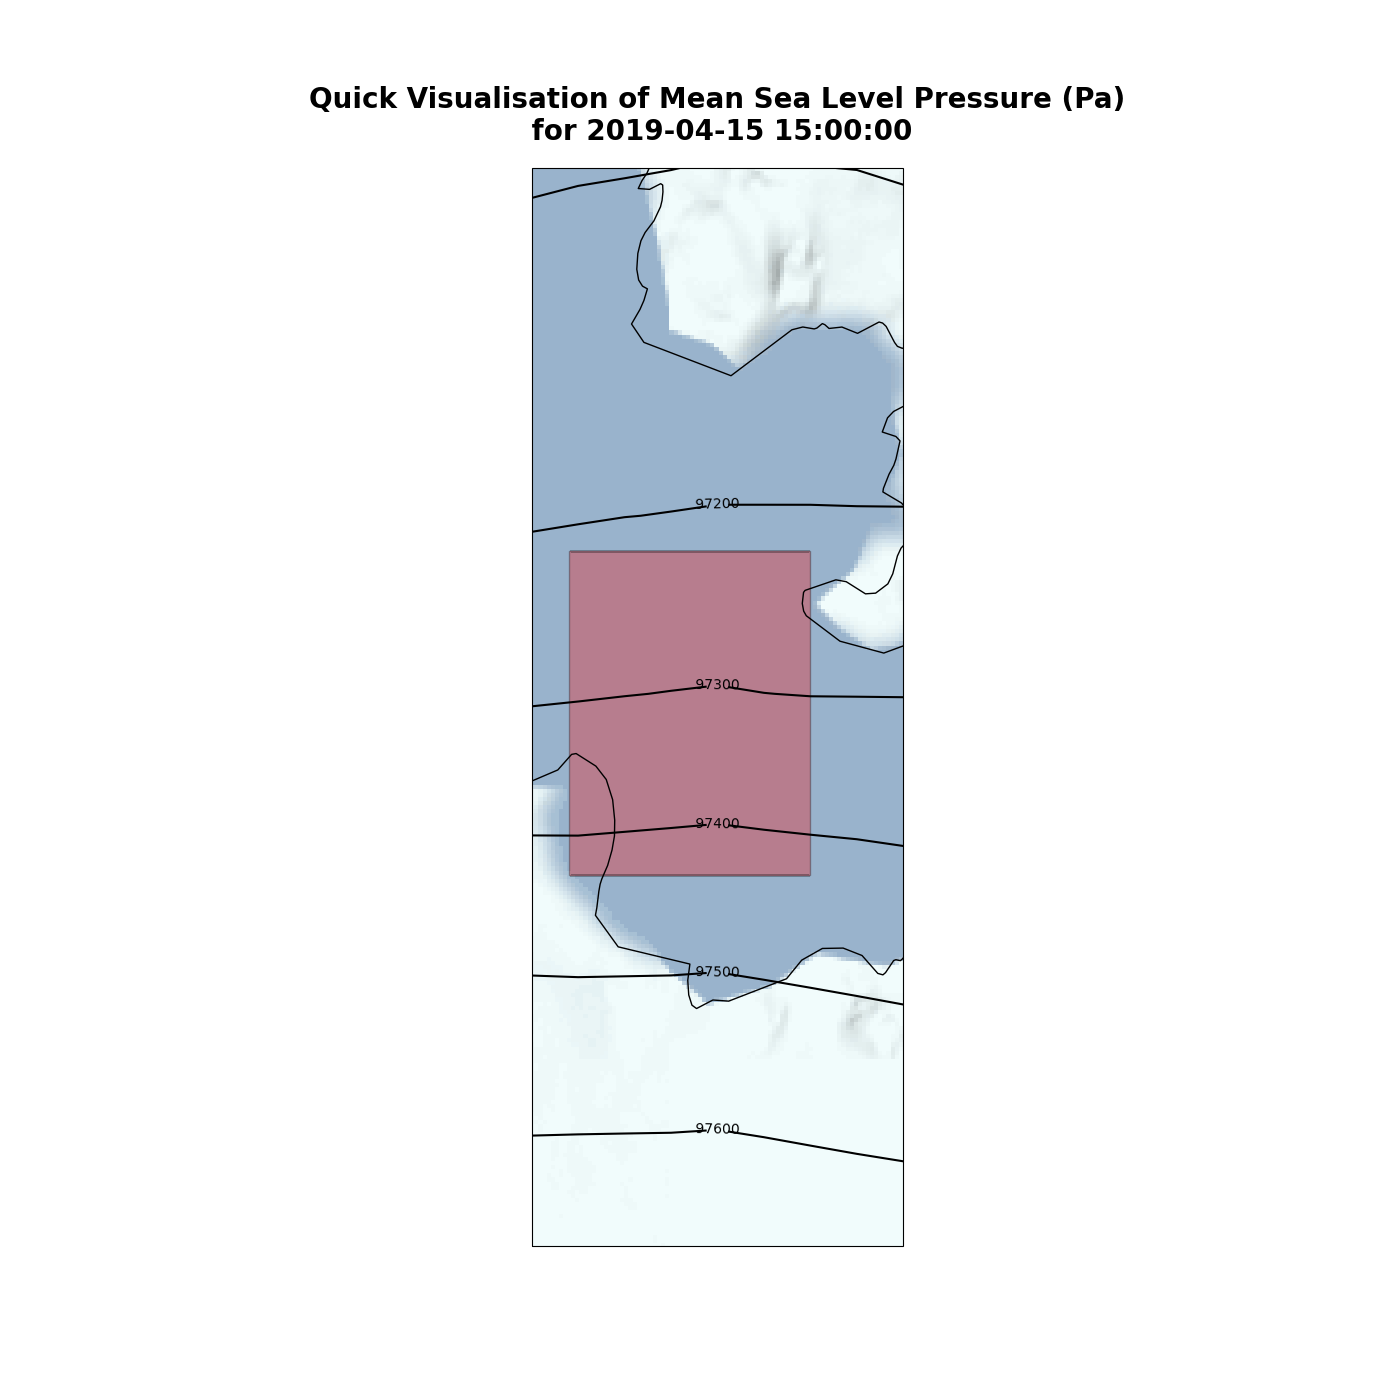

In [40]:
# Load the data for the variable of interest
var = 'msl'
varname = 'Mean Sea Level Pressure (Pa)'
time, lats, lons, vardata = load_data(var)

#The following code isn't working and can't figure it out so will do this the non-modular way for now
# Do some data extraction based on the time frame of interest
#date_i, time_, vardata_ = temporal_mean(period, vardata, time, day= set_date)
date_i = return_date_index(set_date, time)

quick_visualisation(vardata[date_i,0,:,:], lons, lats, varname, time[date_i], filled_contours = 0)


#### Which can be further interpreted by the wind vectors

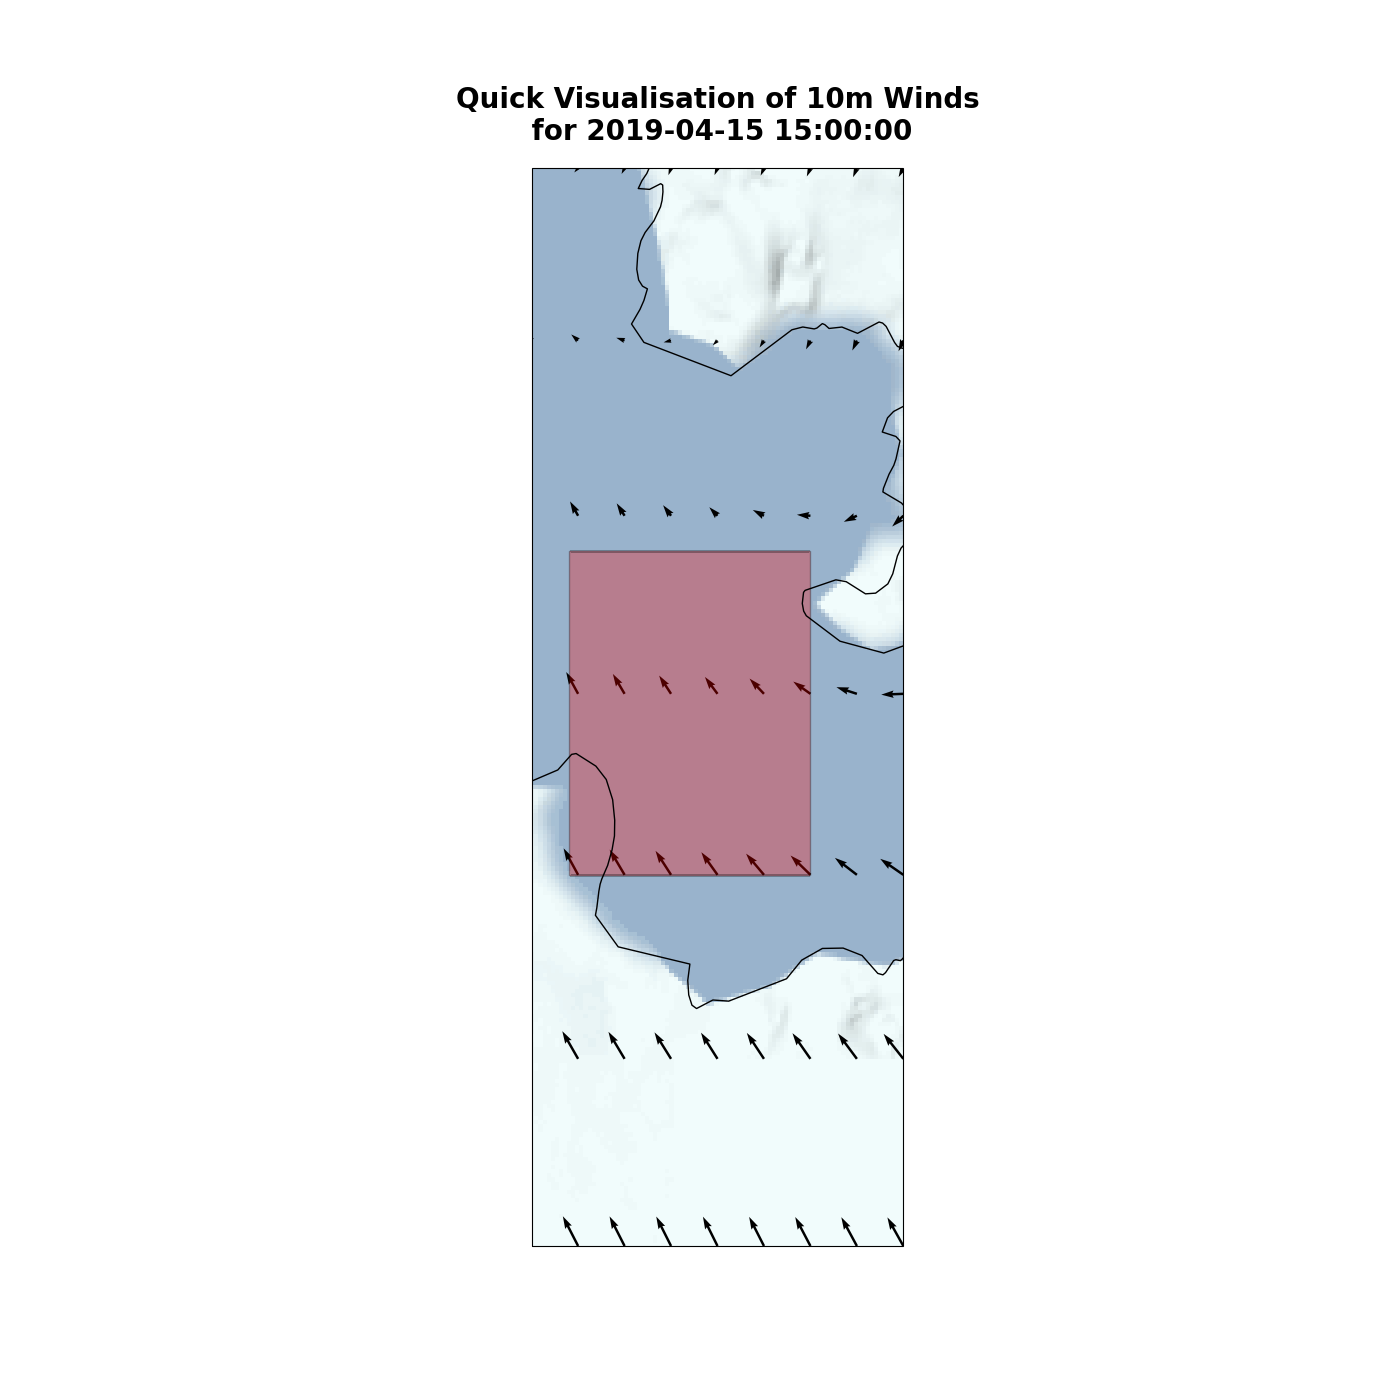

In [41]:
var_u = 'u10'
var_v = 'v10'
varname = '10m Winds'
time, lats, lons, vardata_u = load_data(var_u)
time, lats, lons, vardata_v = load_data(var_v)
quick_visualisation_winds(vardata_u[date_i,0,:,:], vardata_v[date_i,0,:,:], lons, lats, varname, time[date_i])

### Now we can look at some energy fluxes

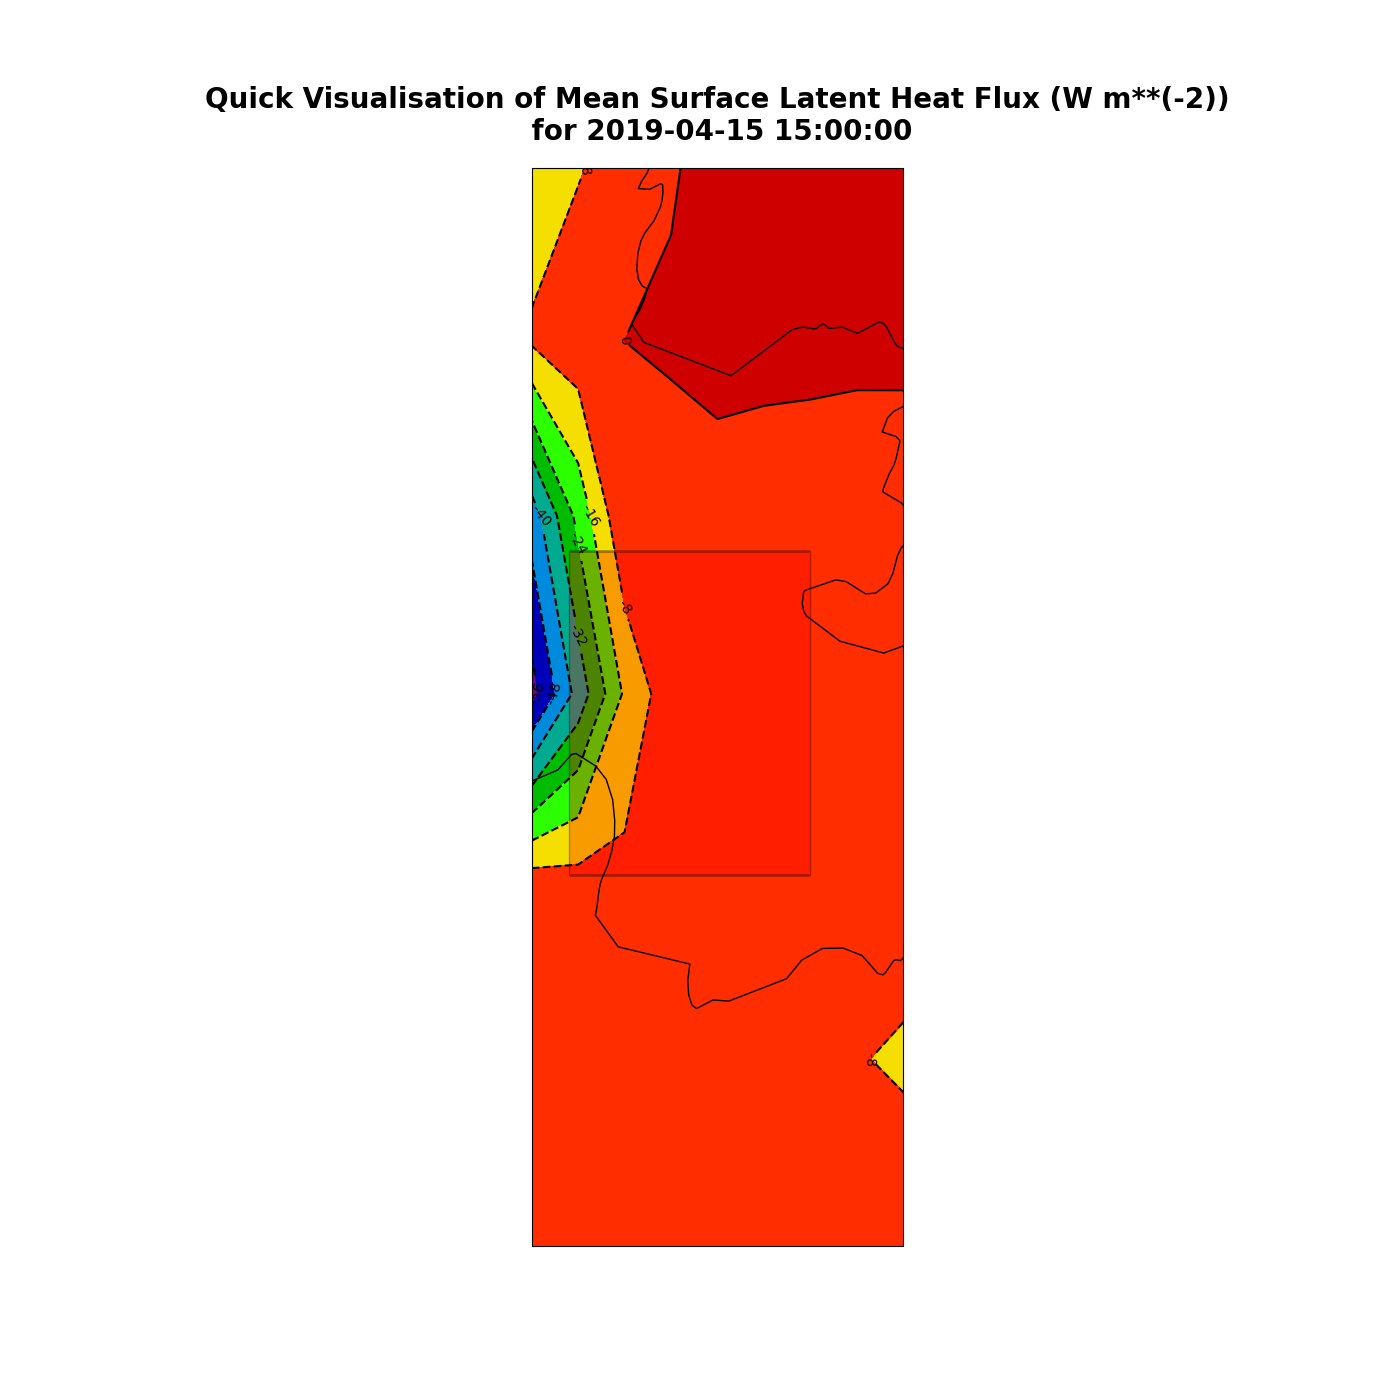

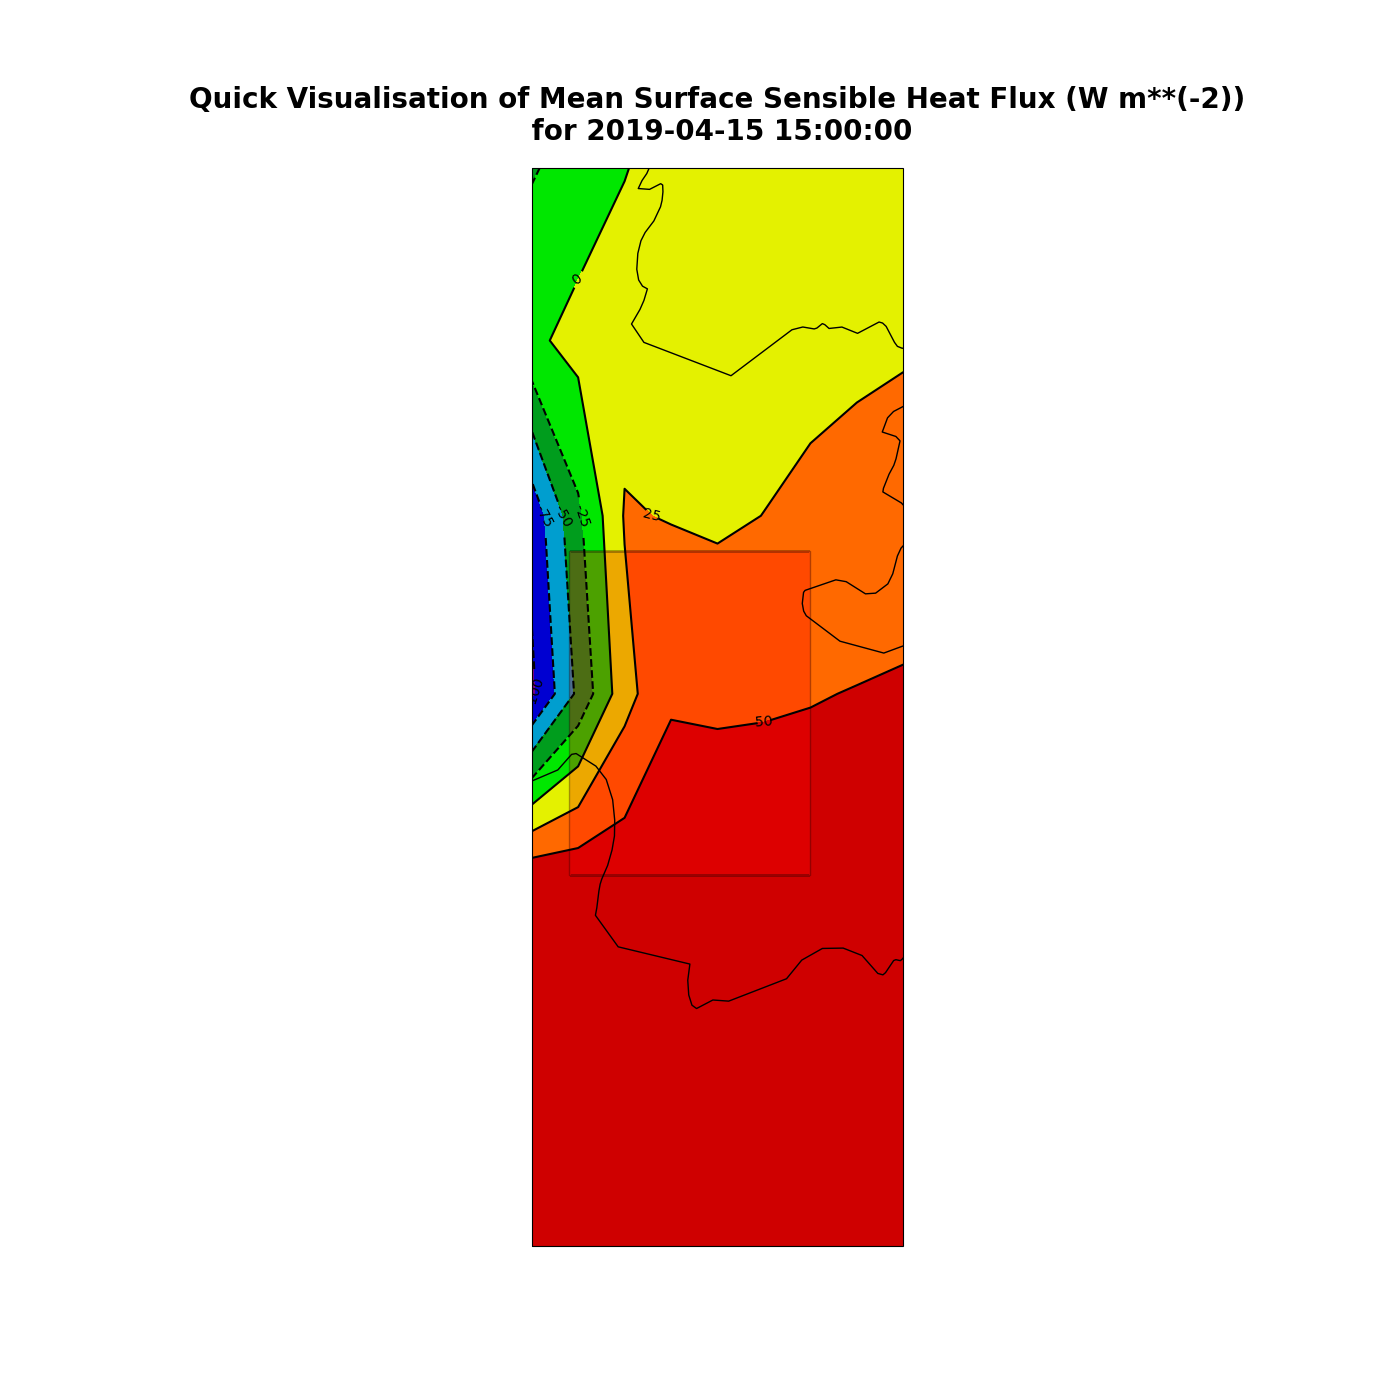

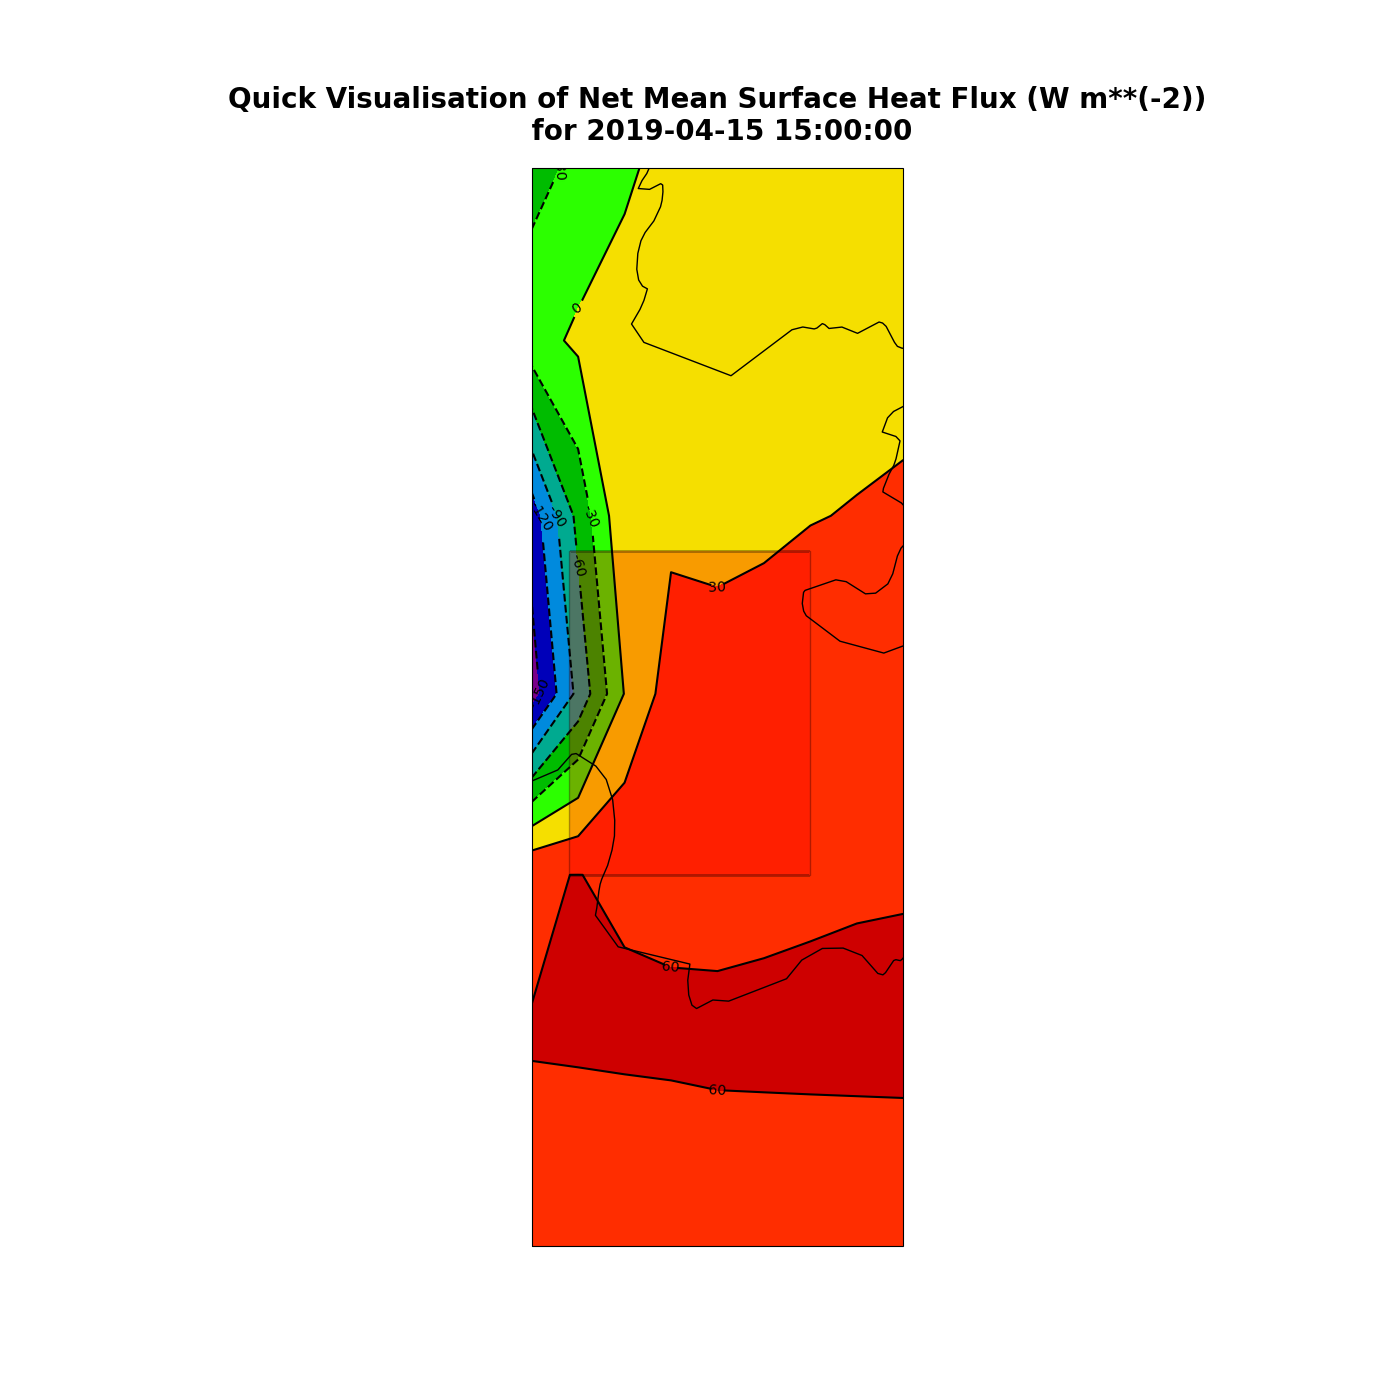

In [42]:
# Load the data for the variable of interest
lh = 'mslhf'
sh = 'msshf'

lhname = 'Mean Surface Latent Heat Flux (W m**(-2))'
shname = 'Mean Surface Sensible Heat Flux (W m**(-2))'

time, lats, lons, lhdata = load_data(lh)
time, lats, lons, shdata = load_data(sh)

date_i = return_date_index(set_date, time)

nethf = (lhdata[date_i,0,:,:] + shdata[date_i,0,:,:])
nethfname = 'Net Mean Surface Heat Flux (W m**(-2))'

quick_visualisation(lhdata[date_i,0,:,:], lons, lats, lhname, time[date_i], filled_contours = 1)
quick_visualisation(shdata[date_i,0,:,:], lons, lats, shname, time[date_i], filled_contours = 1)
quick_visualisation(nethf, lons, lats, nethfname, time[date_i], filled_contours = 1)

### So it seems like the surface heat flux variables do not necessarily capture the Polynya
#### Let's investigate whether any features are captured on average

[1034391 1034415 1034439 ... 1071231 1071255 1071279]
[1034391 1034415 1034439 ... 1071231 1071255 1071279]
(2, 9, 9)
(2, 9, 9)


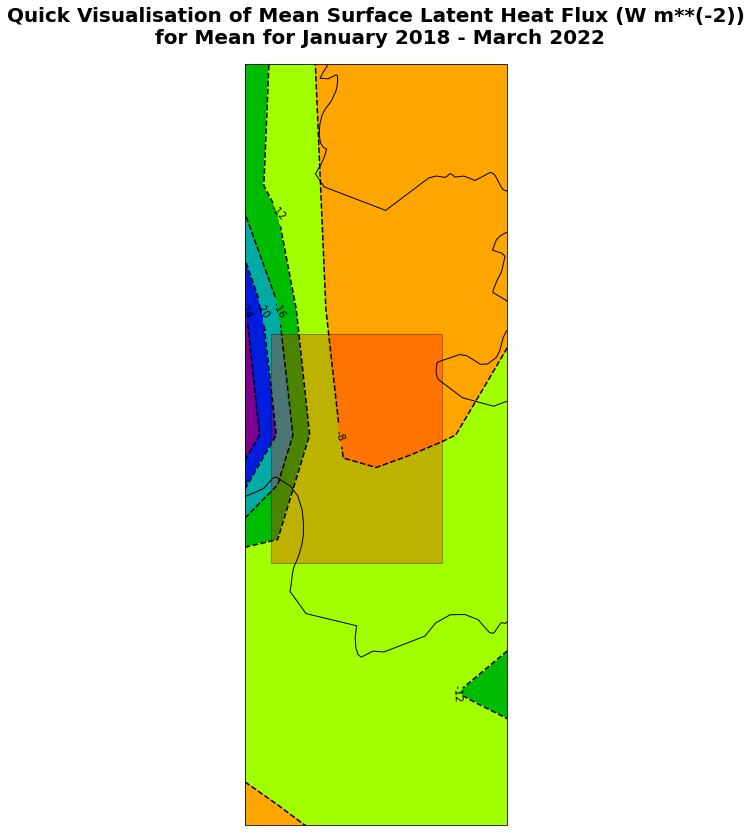

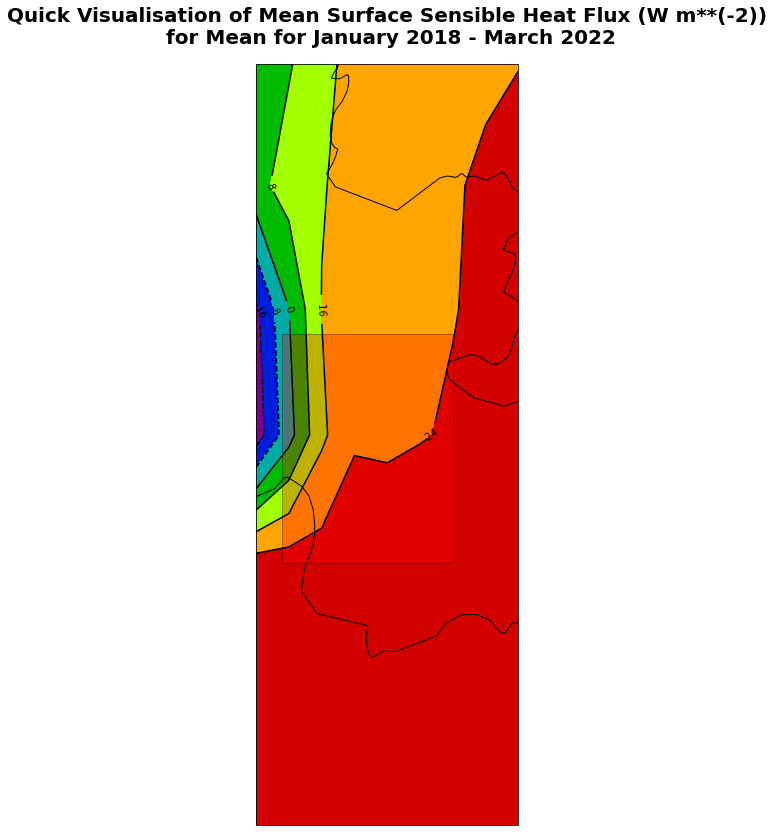

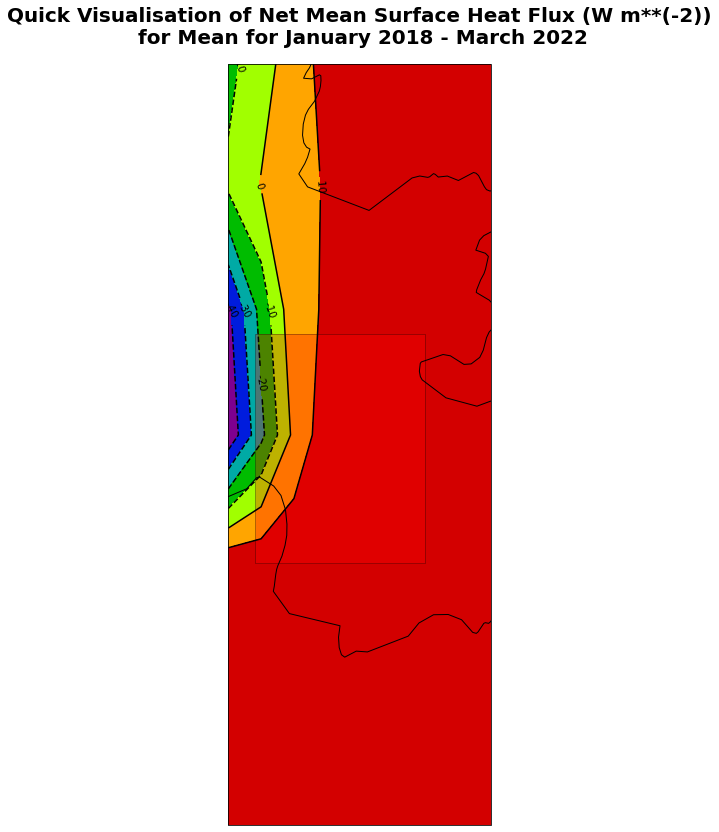

In [119]:
# Load the data for the variable of interest
lh = 'mslhf'
sh = 'msshf'

lhname = 'Mean Surface Latent Heat Flux (W m**(-2))'
shname = 'Mean Surface Sensible Heat Flux (W m**(-2))'

time, lats, lons, lhdata = load_data(lh)
time, lats, lons, shdata = load_data(sh)

lhdata_mn = temporal_mean('yearly', lhdata, time, day=0)
shdata_mn = temporal_mean('yearly', shdata, time, day=0)

nethf_mn = (lhdata_mn[:,:] + shdata_mn[:,:])
nethfname = 'Net Mean Surface Heat Flux (W m**(-2))'

quick_visualisation(lhdata_mn, lons, lats, lhname, 'Mean for January 2018 - March 2022', filled_contours = 1)
quick_visualisation(shdata_mn, lons, lats, shname, 'Mean for January 2018 - March 2022', filled_contours = 1)
quick_visualisation(nethf_mn, lons, lats, nethfname, 'Mean for January 2018 - March 2022', filled_contours = 1)

#### So it's become obvious that while the ERA5 data may help us understand some of the physical mechanisms that contribute to the formation of the Polynya, it cannot resolve the heat flux dynamics over the region. An extension would be to look at the time series of heat flux in the Polynya region and see if the behaviour of the time series mimicks the observed behaviour of the Polynya.

### Given that the ERA5 sea level pressure and winds are more interpretable, we can look at the time series for the Polynya region and assess whether the behaviour mimicks what is observed. 

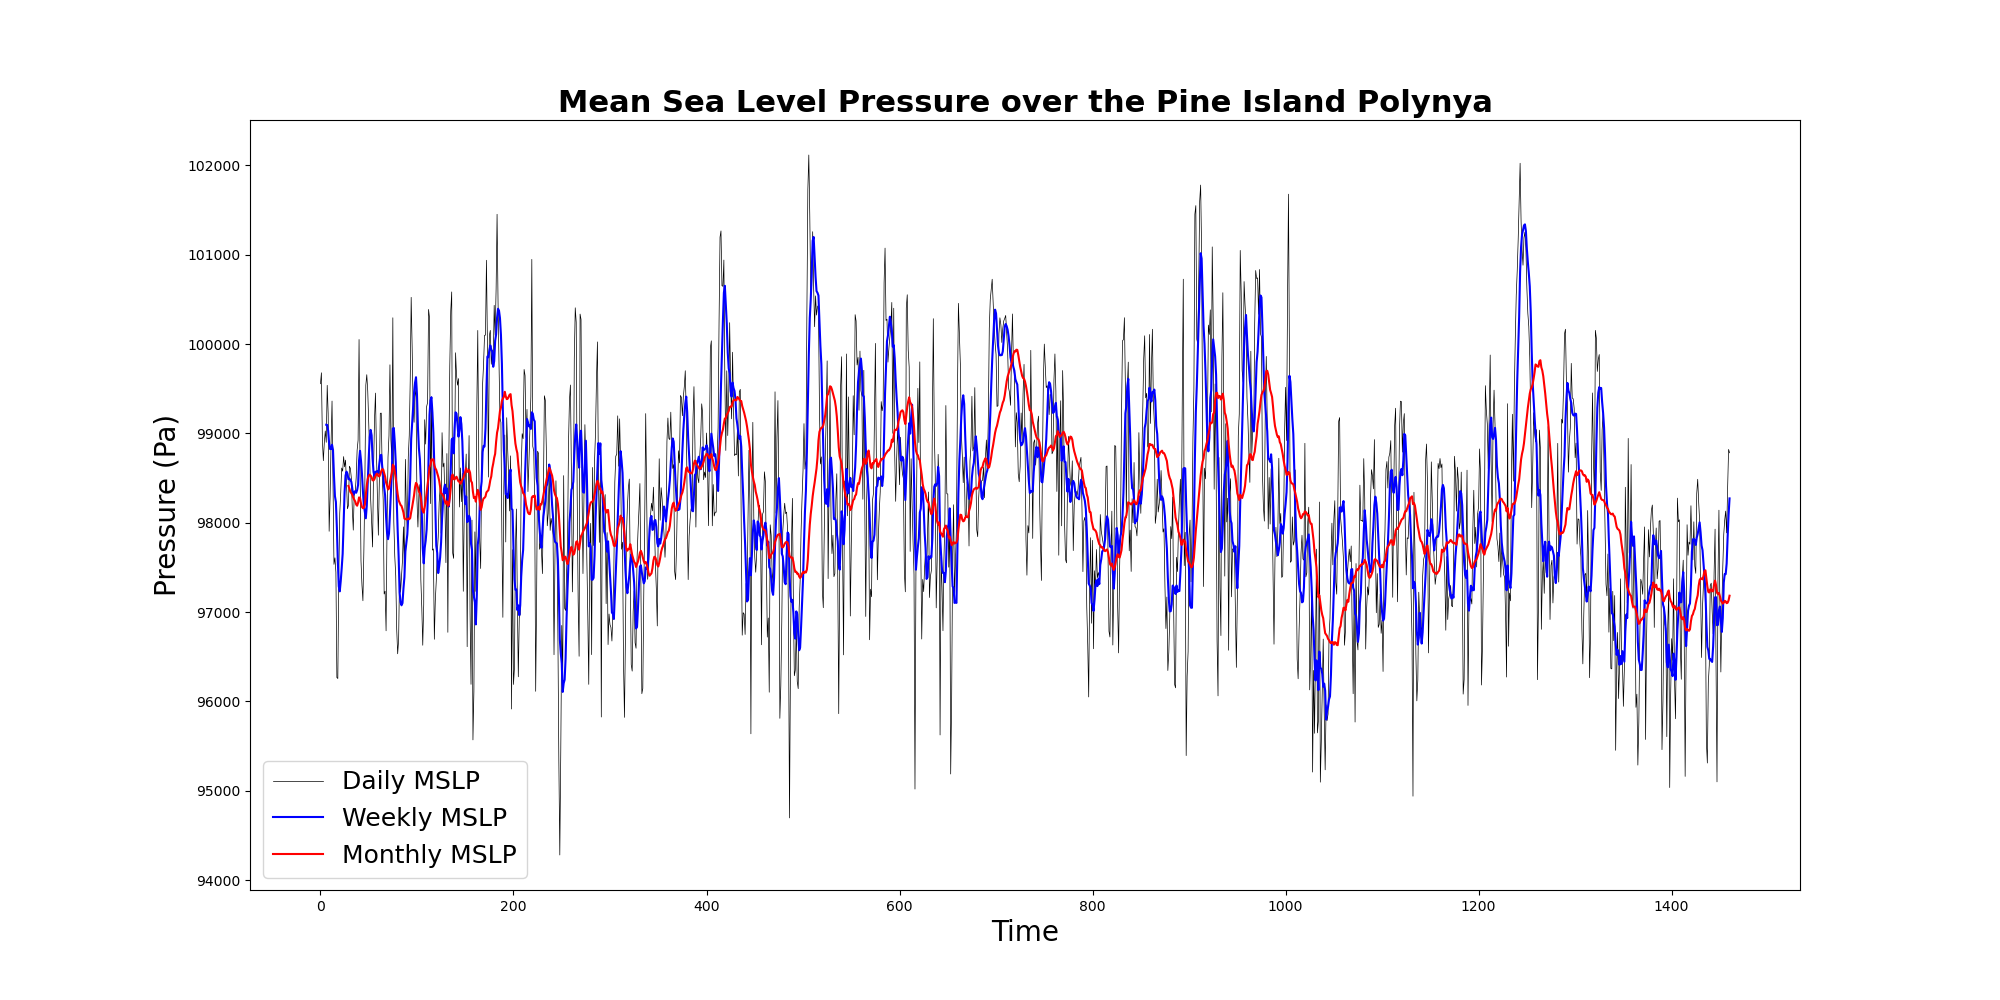

In [43]:
# Load the data for the variable of interest
var = 'msl'
varname = 'Mean Sea Level Pressure (Pa)'
time, lats, lons, vardata = load_data(var)
vardata_mn = spatial_mean(vardata, lats, lons)

quick_visualisation_ts(vardata_mn, varname, time)


## Now let's move on to the three dimensional plots with ICESat-2 Tracks

In [13]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [14]:
PIG_20201007_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-10-07&minx=-101.06993207685464&miny=-75.06319452393107&maxx=-100.2946192252&maxy=-74.74165227279721&trackId=210&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20201007_gtx = 'gt2r'

In [15]:
def data_from_oa_url(url,gtx):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    return (mydata)

In [16]:
def is2_featurecollection(data):
    ground_track_coordinates = list(zip(data.atl08.lon, data.atl08.lat))
    ground_track_projection = 'EPSG:4326' 
    gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
    return gtx_feature

In [80]:
PIG_20201007_data = data_from_oa_url(PIG_20201007_url, PIG_20201007_gtx)
atl06_data = PIG_20201007_data.atl06
atl06_lat = atl06_data['lat']
atl06_lon = atl06_data['lon']
atl06_h = atl06_data['h']

new_lons, new_lats = np.meshgrid(atl06_lon, atl06_lat)

In [85]:
var = 'msl'
varname = 'Mean Sea Level Pressure (Pa)'
time, lat, lon, vardata = load_data(var)
old_lon, old_lat = np.meshgrid(lon, lat)


date_i = return_date_index(set_date, time)

vardata_old = vardata[date_i,0,:,:]
time_ = time[date_i]

#interp
new_grid=griddata((old_lon.flatten(),old_lat.flatten()),vardata_old.flatten() , (new_lons,new_lats),method='cubic')


/tmp/ipykernel_664/293634883.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax     = fig.gca(projection='3d')


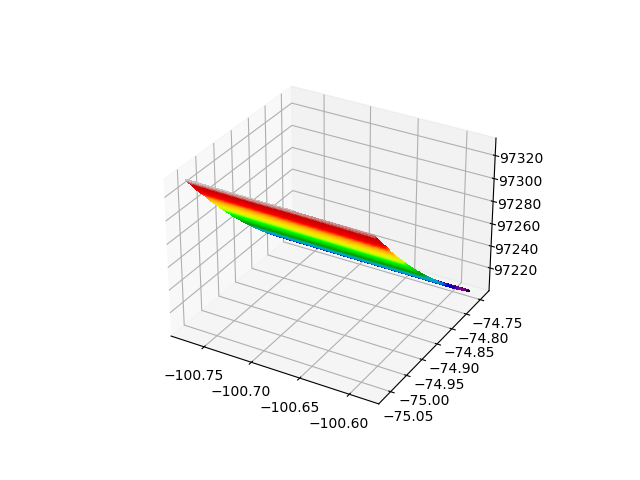

In [104]:
fig    = plt.figure()
ax     = fig.gca(projection='3d')

#x      = np.linspace(0, 1, 100)
#X, Y   = np.meshgrid(x, x)
#levels = np.linspace(-0.1, 0.4, 100)  #(z_min,z_max,number of contour),

#a=0
#b=1
#c=2
#Z1 = a+.1*np.sin(2*X)*np.sin(4*Y)
#Z2 = b+.1*np.sin(3*X)*np.sin(4*Y)
#Z3 = c+.1*np.sin(4*X)*np.sin(5*Y)

#plt.contourf(old_lon, old_lat, vardata_old, levels =100, zdir='z',cmap=plt.get_cmap('nipy_spectral'))
#line_c = plt.contour(old_lon, old_lat, vardata_old, colors=['black'])
#ax.clabel(
#        line_c,  # Typically best results when labelling line contours.
#        colors=['black'],
#        manual=False,  # Automatic placement vs manual placement.
#        inline=True,  # Cut the line where the label will be placed.
#        fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
#    )
#plt.p

plt.contourf(new_lons, new_lats, new_grid, levels =100, cmap=plt.get_cmap('nipy_spectral'))
#line_c = plt.contour(new_lons, new_lats, new_grid, colors=['black'])
#plt.clabel(
#        line_c,  # Typically best results when labelling line contours.
#        colors=['black'],
 #       manual=False,  # Automatic placement vs manual placement.
  #      inline=True,  # Cut the line where the label will be placed.
   #     fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
    #)
#plt.plot(atl06_lon, atl06_lat, atl06_h, 'red')
#plt.contourf(X, Y,Z3, levels=c+levels,cmap=plt.get_cmap('rainbow'))
#ax.set_xlim3d(0, 1)
#ax.set_ylim3d(0, 1)
#ax.set_zlim3d(0, 2)

plt.show()

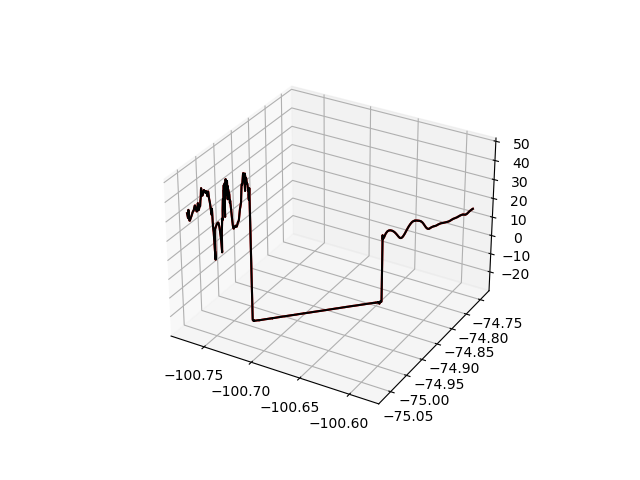

In [44]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(atl06_lon, atl06_lat, atl06_h, 'red')
